In [1]:
%matplotlib inline

from matplotlib import rc
from fourierPSF.fourierModel import *
from fourierPSF.FourierUtils import *

from mavis import *

rc("text", usetex=False)

In [2]:
def overallSimulation(path, parametersFile, windPsdFile, outputDir, outputFile, hh=1):
    fullPathFilename = path + parametersFile + '.ini'    
    parser = ConfigParser()
    parser.read(fullPathFilename);
    wvl = eval(parser.get('PSF_DIRECTIONS', 'ScienceWavelength'))[0]  # lambda
    tel_radius = eval(parser.get('PSF_DIRECTIONS', 'psInMas'))/2
    pixel_psf = eval(parser.get('telescope', 'TelescopeDiameter'))      # mas
    LO_zen = eval(parser.get('SENSOR_LO', 'GuideStarZenith_LO')) 
    LO_az = eval(parser.get('SENSOR_LO', 'GuideStarAzimuth_LO'))
    fluxes = eval(parser.get('SENSOR_LO', 'nph_LO'))
    fr = eval(parser.get('SENSOR_LO', 'SensorFrameRate_LO'))
    polarNGSCoordsList = [[LO_zen[0],LO_az[0]], [LO_zen[1],LO_az[1]],[LO_zen[2],LO_az[2]]]
    NGS_flux = [fluxes[0]*fr, fluxes[1]*fr, fluxes[2]*fr]
    polarNGSCoords = np.asarray(polarNGSCoordsList)
    # gridElements = 5
    # xxPointigsV , yyPointigsV =  np.linspace(-15, 15, gridElements), np.linspace(-15,15, gridElements) 
    zenithSrc      = np.array(eval(parser.get('PSF_DIRECTIONS', 'ScienceZenith')))
    azimuthSrc     = np.array(eval(parser.get('PSF_DIRECTIONS', 'ScienceAzimuth')))
    pp = polarToCartesian(np.array( [zenithSrc, azimuthSrc]))
    xxPointigs = pp[0,:]
    yyPointigs = pp[1,:]
    # xxPointigs, yyPointigs = np.meshgrid(xxPointigsV , yyPointigsV)
    fao = fourierModel(fullPathFilename, calcPSF=False, verbose=False, display=False, \
                   cartPointingCoords=np.array([xxPointigs, yyPointigs]).transpose() , extraPSFsDirections=polarNGSCoordsList)
    PSD = fao.powerSpectrumDensity()
    PSD = PSD.transpose()
    N = PSD[0].shape[0]    
    freq_range = fao.fovInPixel*fao.PSDstep # fao.psf_FoV/fao.wvlRef/206264.8
    pitch = 1/freq_range
    grid_diameter = pitch*N
    scaleFactor = (2*np.pi*1e-9/wvl)**2
    dk = 2*fao.kc/fao.resAO * 1e9
    mask = Field(wvl, N, pitch*N)
    print(TelescopeDiameter/pitch)
    sx = int(TelescopeDiameter/pitch)+hh
    
    mask.sampling = cp.asarray(congrid(fao.tel.pupil, [sx, sx]))
    mask.sampling = zeroPad(mask.sampling, (N-sx)//2)
    
    print('fao.samp:', fao.samp)


    def psdSetToPsfSet(inputPSDs):
        NGS_SR_1650 = []
        psdArray = []
        psfLongExpArr = []
        NGS_FWHM_mas = []
        for computedPSD in inputPSDs:    
            psd = Field(wvl, N, freq_range, 'rad')
            psd.sampling = cp.asarray(computedPSD / dk**2 )
            psfLongExp = longExposurePsf(mask, psd )            
            scaledSampling = computedPSD * scaleFactor
            sr1 = np.exp(-scaledSampling.sum())
            print('sr1:', sr1)
            sr2 = getStrehl( cp.asnumpy(psfLongExp.sampling), fao.tel.pupil, fao.samp)
            print('sr2:', sr2)
            fw1 = np.hypot(psfLongExp.FWHM()[0],psfLongExp.FWHM()[1]) * 180 / np.pi * 3600 * 1000
            print('fw1:', fw1)
            fw2 =  getFWHM( cp.asnumpy(psfLongExp.sampling), psfLongExp.pixel_size, method='contour', nargout=1) * 180 / np.pi * 3600 * 1000
            print('fw2:', fw2)            
            NGS_SR_1650.append(sr2)
            psdArray.append(psd)
            psfLongExpArr.append(psfLongExp)
            NGS_FWHM_mas.append(fw2)

        return NGS_SR_1650, psdArray, psfLongExpArr, NGS_FWHM_mas

    NGS_SR_1650, psdArray, psfLongExpArr, NGS_FWHM_mas = psdSetToPsfSet(PSD[-3:])
        
    cartPointingCoords =  np.dstack( (xxPointigs, yyPointigs) ).reshape(-1, 2)
    cartNGSCoords = np.asarray([polarToCartesian(polarNGSCoords[0,:]), polarToCartesian(polarNGSCoords[1,:]), polarToCartesian(polarNGSCoords[2,:])])
    mLO = MavisLO(path, parametersFile, windPsdFile)
    Ctot = mLO.computeTotalResidualMatrix(np.array(cartPointingCoords), cartNGSCoords, NGS_flux, NGS_SR_1650, NGS_FWHM_mas)
    cov_ellipses = mLO.ellipsesFromCovMats(Ctot)
    
    pointings_SR_1650, psdPointingsArray, psfLongExpPointingsArr, pointings_FWHM_mas = psdSetToPsfSet(PSD[:-3])
    
    results = []
    for ellp, psfLongExp in zip(cov_ellipses, psfLongExpPointingsArr):
        results.append(convolve(psfLongExp, residualToSpectrum(ellp, N, fao.psf_FoV)))

    psfLongExpPointingsArr[0].standardPlot(True)
    results[0].standardPlot(True)

    plotEllipses(cartPointingCoords, cov_ellipses, 0.2)
    tiledDispaly(results)

    # save PSF cube in fits    
    hdul1 = fits.HDUList()
    cube =[]
    hdul1.append(fits.PrimaryHDU())
    for img in psfLongExpPointingsArr:
        cube.append(cp.asnumpy(img.sampling))
        
    hdul1.append(fits.ImageHDU(data=np.array(cube)))
    hdul1.writeto( outputDir + outputFile + '.fits')

315.52105312102924
fao.samp: 1.0
sr1: 0.03339209764858256
sr2: 0.4195655456524359
fw1: 16.130732196824248
fw2: 16.686882455097646
sr1: 0.016558536857690067
sr2: 0.35374938331322303
fw1: 16.21124352694189
fw2: 16.70076499483551
sr1: 0.014287141672181349
sr2: 0.3438238727010752
fw1: 16.25858766089144
fw2: 16.74742402326907
sr1: 0.08476903653994516
sr2: 0.5269252964834145
fw1: 16.098085715776843
fw2: 16.662906696290605
sr1: 0.07559482700769521
sr2: 0.5118257987988982
fw1: 16.06965417403089
fw2: 16.653367816312993
sr1: 0.08236781639437238
sr2: 0.5215975634982403
fw1: 16.00899536781926
fw2: 16.634528492029272
sr1: 0.10242881321813571
sr2: 0.5496437174667032
fw1: 15.986425907536745
fw2: 16.624451329177425
sr1: 0.06630085609744585
sr2: 0.4956958226321274
fw1: 16.072778629792364
fw2: 16.655614681134796
sr1: 0.06921095100602447
sr2: 0.5001261490948221
fw1: 16.042945885932063
fw2: 16.639669271111416
sr1: 0.08195016057731794
sr2: 0.5202505908124069
fw1: 15.992235800045565
fw2: 16.621199179759394


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


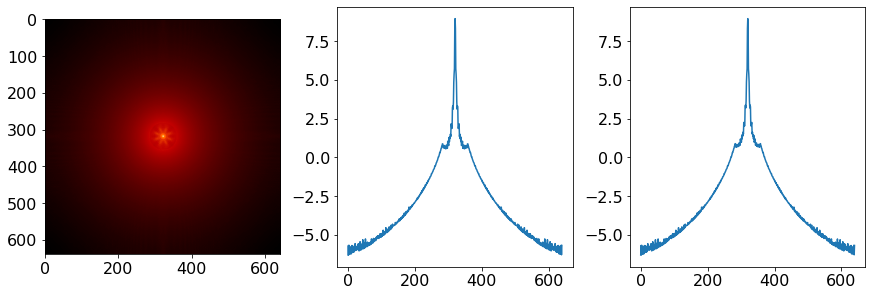

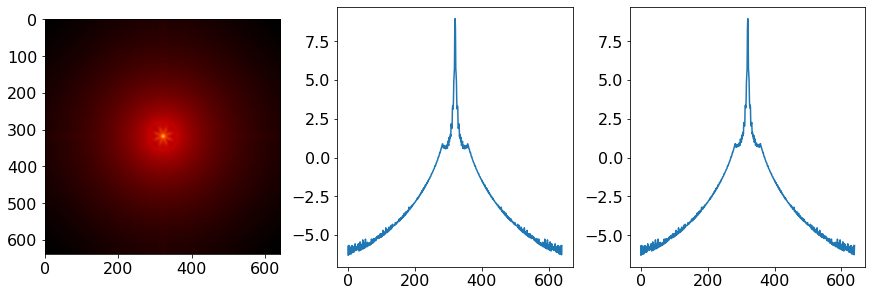

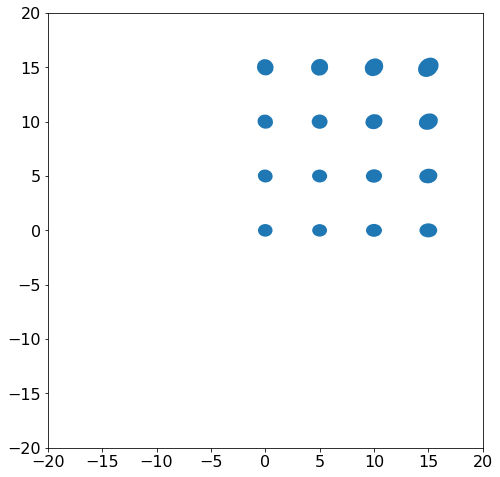

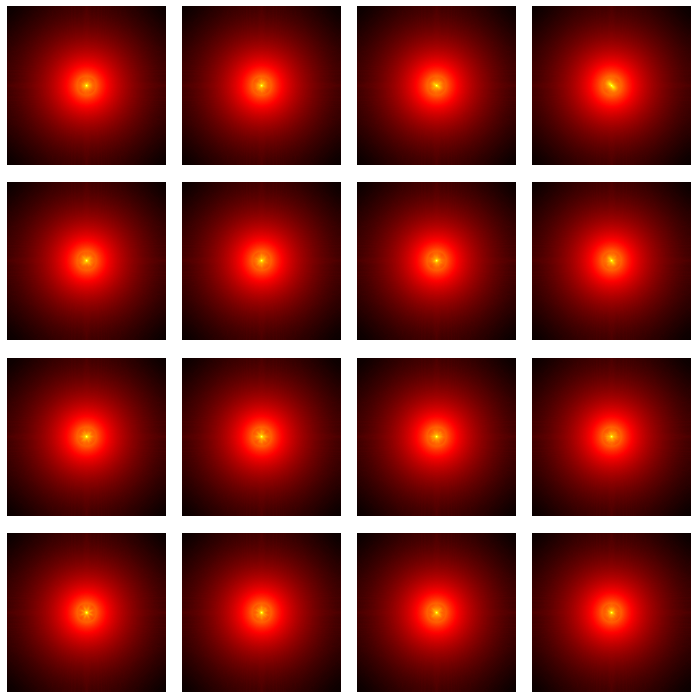

315.47090673623563
fao.samp: 1.0
sr1: 0.10264936329899343
sr2: 0.5506639083949769
fw1: 19.594993244339882
fw2: 20.342483235885666
sr1: 0.06417805151659066
sr2: 0.49109611778623236
fw1: 19.650195846838123
fw2: 20.350678793929713
sr1: 0.058140824481064335
sr2: 0.4818066977112862
fw1: 19.686821049064363
fw2: 20.387809999776337
sr1: 0.19155923174018136
sr2: 0.6415135721797557
fw1: 19.57421815348287
fw2: 20.32492694775727
sr1: 0.17741687983891063
sr2: 0.6291588012022542
fw1: 19.551819025576332
fw2: 20.31737444256325
sr1: 0.18790378949180228
sr2: 0.6371919289300756
fw1: 19.503990848922843
fw2: 20.302500965184258
sr1: 0.21742649615357934
sr2: 0.6599358586239107
fw1: 19.486324016886652
fw2: 20.294528689547565
sr1: 0.16249642076153376
sr2: 0.61580925448025
fw1: 19.554007310568174
fw2: 20.31907900422003
sr1: 0.16723699229480676
sr2: 0.6194957097163896
fw1: 19.53038230694186
fw2: 20.306294734799568
sr1: 0.18726422020876138
sr2: 0.6360910397642583
fw1: 19.49047663959002
fw2: 20.291675763581377
sr1

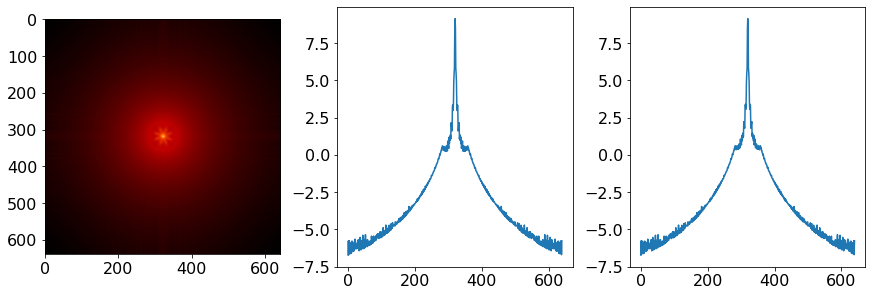

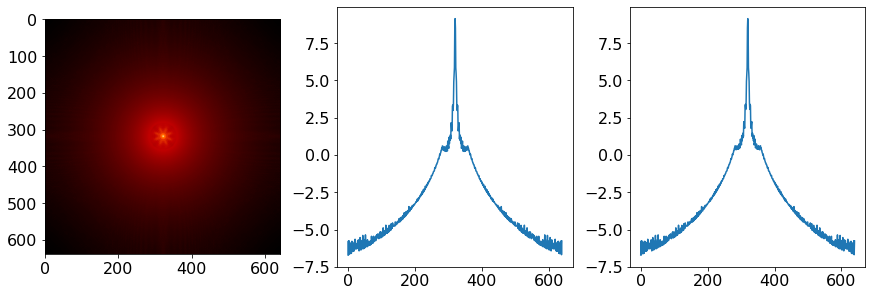

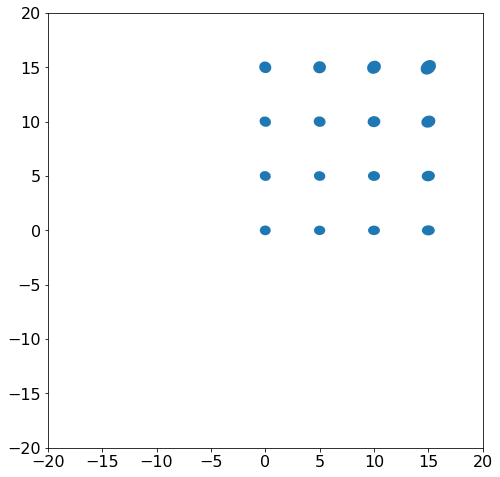

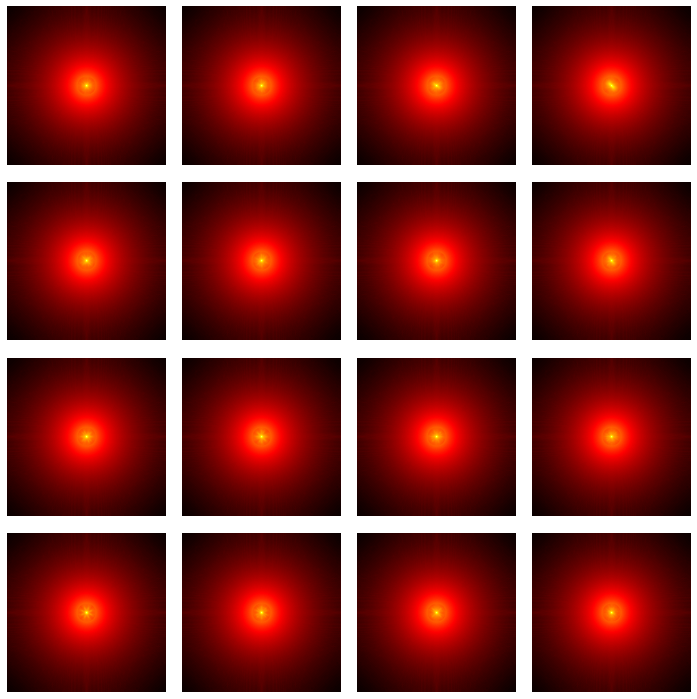

315.32281819364226
fao.samp: 1.0
sr1: 0.185919838307978
sr2: 0.636070459326722
fw1: 22.724061477290608
fw2: 23.631529420608924
sr1: 0.13138969393649413
sr2: 0.5844495954335004
fw1: 22.767225221406886
fw2: 23.637279520299007
sr1: 0.12213897920810422
sr2: 0.576255738126392
fw1: 22.797851341963472
fw2: 23.668725076474097
sr1: 0.29488308136648395
sr2: 0.7120655647938302
fw1: 22.708655519541566
fw2: 23.617321297683894
sr1: 0.27863453482762485
sr2: 0.7019193865053863
fw1: 22.68980901475899
fw2: 23.61095252002654
sr1: 0.2906871060610346
sr2: 0.7085191884729428
fw1: 22.649541569200196
fw2: 23.59842720492363
sr1: 0.3237738469880219
sr2: 0.7271024546102798
fw1: 22.634720990550406
fw2: 23.59170318056163
sr1: 0.26111039146587534
sr2: 0.690883500372026
fw1: 22.691538855477273
fw2: 23.612361170420726
sr1: 0.26670971085356626
sr2: 0.6939332988317832
fw1: 22.671597021332683
fw2: 23.601503085703836
sr1: 0.28996244401373494
sr2: 0.7076205630544682
fw1: 22.638029404587716
fw2: 23.5891717901022
sr1: 0.284

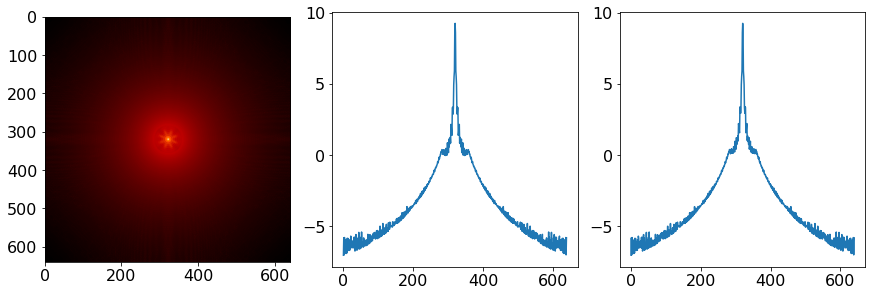

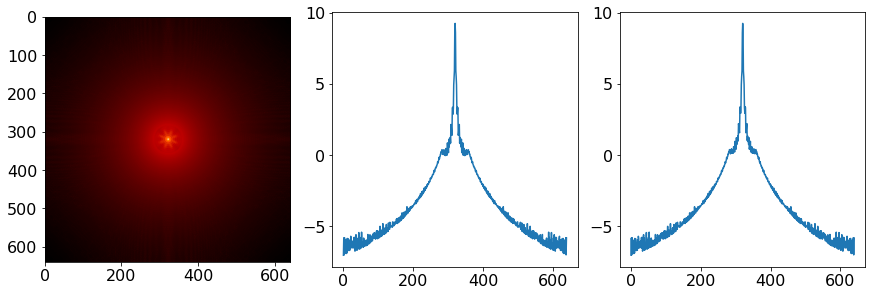

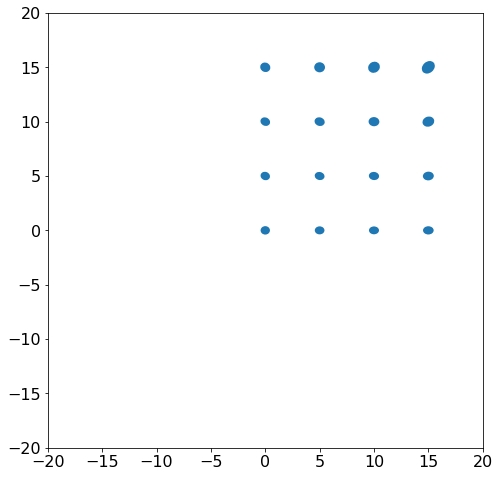

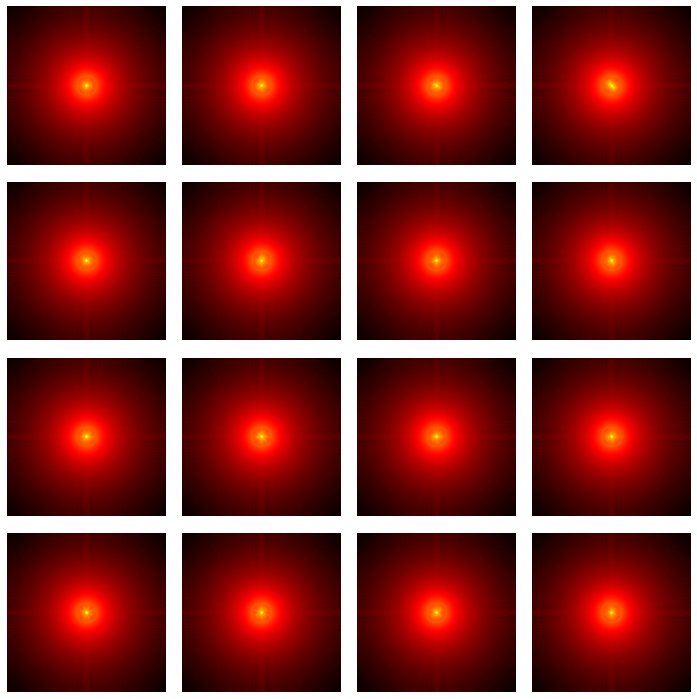

315.4404808398441
fao.samp: 1.0
sr1: 0.41914286195866113
sr2: 0.774253999175612
fw1: 31.494307570378222
fw2: 32.8234475632244
sr1: 0.3503122745587798
sr2: 0.7410490389767529
fw1: 31.521672829465864
fw2: 32.82642906293242
sr1: 0.33733965622285034
sr2: 0.7356505940849819
fw1: 31.542996328089366
fw2: 32.84869120322951
sr1: 0.5319362241330714
sr2: 0.8208132562131383
fw1: 31.48538025423106
fw2: 32.813988836896854
sr1: 0.5165799362817222
sr2: 0.8147460680214214
fw1: 31.472162923869867
fw2: 32.80951151799324
sr1: 0.5280328408863065
sr2: 0.8187148180551057
fw1: 31.443883222055504
fw2: 32.800713805423676
sr1: 0.5582976900769353
sr2: 0.8297598215956693
fw1: 31.433530516369213
fw2: 32.79598081707317
sr1: 0.49953385255078064
sr2: 0.8080967904042541
fw1: 31.47327088310369
fw2: 32.81047487604934
sr1: 0.5050498698448828
sr2: 0.8099456013452155
fw1: 31.459224177249904
fw2: 32.802762727629485
sr1: 0.5273449537480552
sr2: 0.8181751717805966
fw1: 31.435679505777006
fw2: 32.794081976807924
sr1: 0.52187379

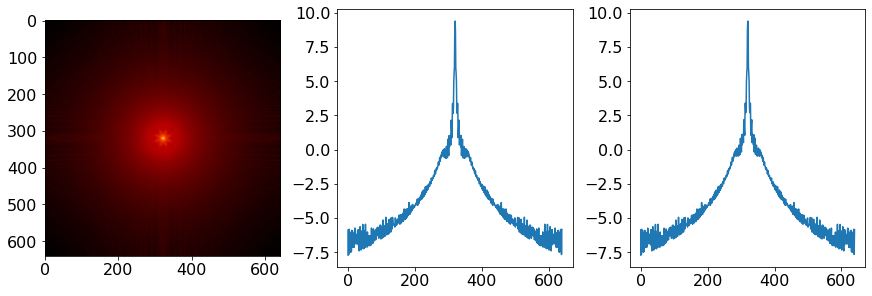

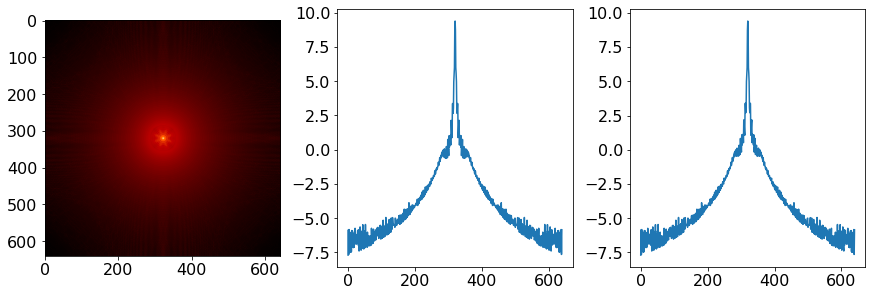

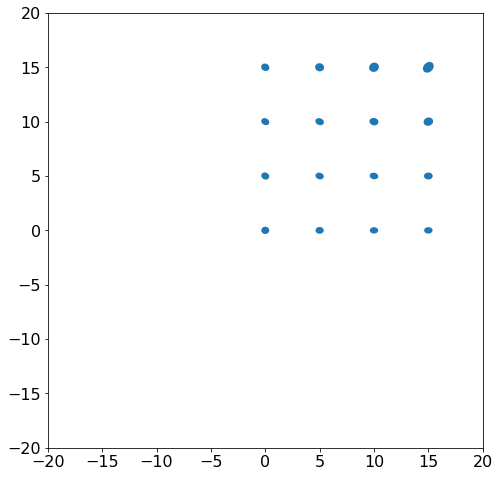

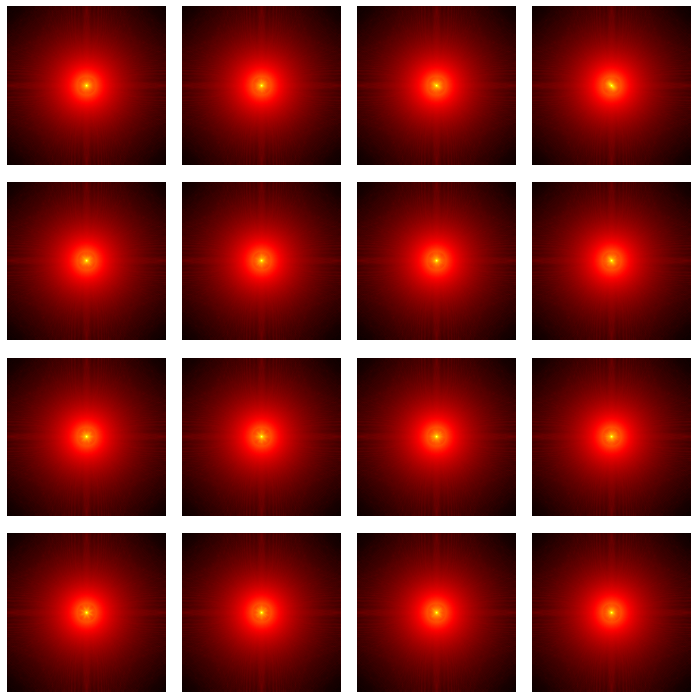

In [3]:
baseInputPath = '/data7/guido/results/MAVIS/res4psf/20201116_111006.0_oaPSFs_w'
baseOutpuPath = '/data4/frossi/'
windPsdFile = 'data/windpsd_mavis.fits'

wvlPaths = ['450', '550', '640', '890']
for wvlPath in wvlPaths:
    fullInputPath = baseInputPath + wvlPath + 'nm/'
    parametersFile = 'params'
    outputFile = 'simulation' + wvlPath + 'nm'
    overallSimulation(fullInputPath, parametersFile, windPsdFile, baseOutpuPath, outputFile)

200.00988414173906
fao.samp: 1.1149448986329533
sr1: 0.05990988355947293
sr2: 0.49446889923713083
fw1: 23.34967205496465
fw2: 23.826975421654467
sr1: 0.0005348733542717612
sr2: 0.17033472255499058
fw1: 46.94635837810025
fw2: 26.356235918415244
sr1: 0.4352715080419849
sr2: 0.8001175603431903
fw1: 22.66198358397385
fw2: 23.507132640851832
sr1: 0.42458325716742623
sr2: 0.7951492706490938
fw1: 22.68345885549315
fw2: 23.514479803475993
sr1: 0.42548200826928784
sr2: 0.7953826055905214
fw1: 22.671723882165004
fw2: 23.510184511348157
sr1: 0.4423125270331263
sr2: 0.802892543135545
fw1: 22.653187201340497
fw2: 23.50392926106696
sr1: 0.4491744253018992
sr2: 0.8061028148464034
fw1: 22.656802705499338
fw2: 23.504323497245455
sr1: 0.41551690015410014
sr2: 0.7907301584261776
fw1: 22.675017012582106
fw2: 23.511642161331647
sr1: 0.4234969768549736
sr2: 0.7942987144558754
fw1: 22.66184124020729
fw2: 23.504815932699053
sr1: 0.4386002319181424
sr2: 0.8011565068536781
fw1: 22.647228906101116
fw2: 23.499813

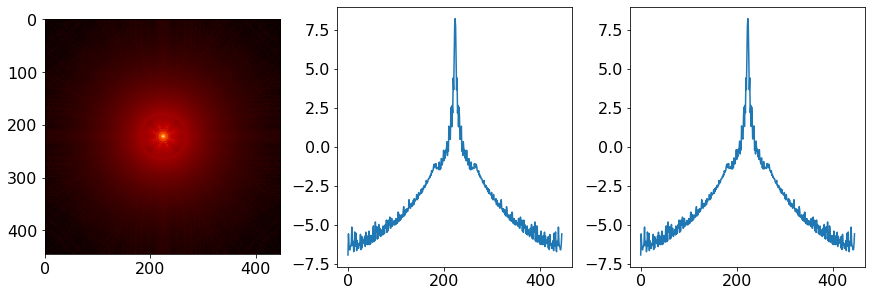

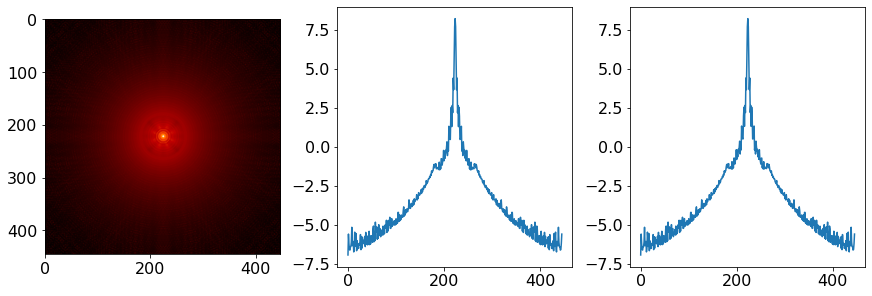

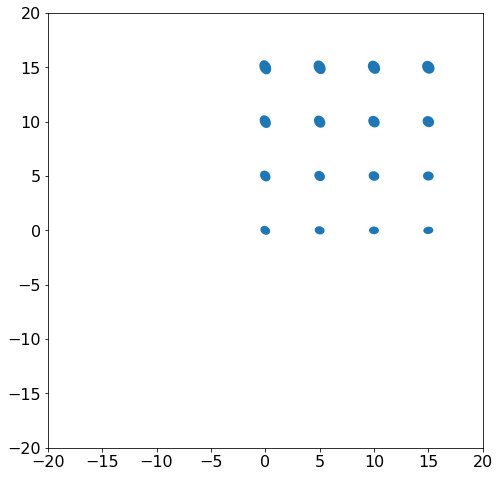

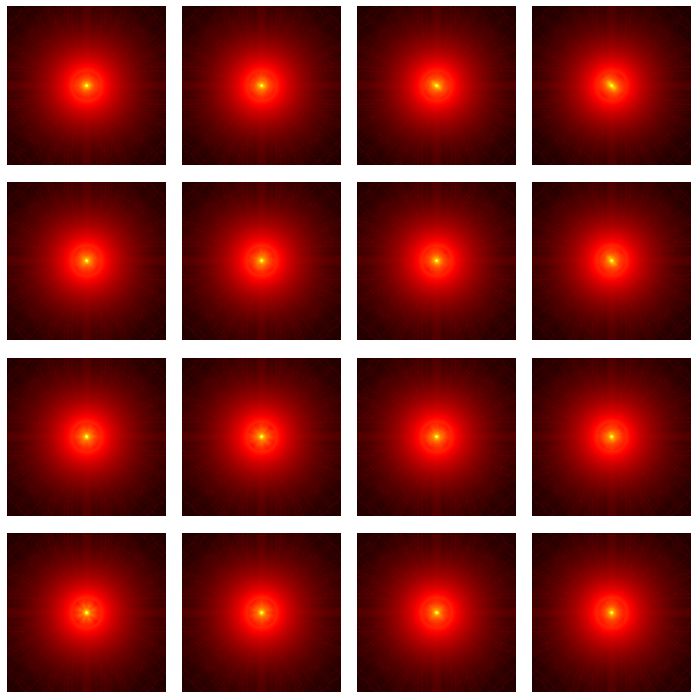

In [4]:
path = "/home/frossi/dev/MASTSEL/"
parametersFile = 'mavisParams'
windPsdFile = 'data/windpsd_mavis.fits'
baseOutpuPath = '/data4/frossi/'

overallSimulation(path, parametersFile, windPsdFile, baseOutpuPath, "test", hh=0)

In [5]:
# NGS_flux = [10000, 30000, 5000]
# old values: NGS_SR_1650 = [0.4, 0.2, 0.6]
# old values: NGS_FWHM_mas = [90, 110, 85]